In [137]:
%load_ext autoreload
%autoreload 2
from src.util import utilities as util

import cv2
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[[255   0   0]
  [  0 255   0]
  [  0   0 255]]

 [[255 255 255]
  [128 128 128]
  [  0   0   0]]]


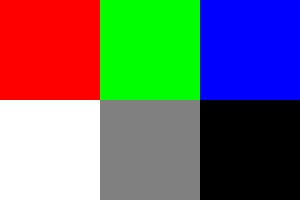

In [138]:
image = cv2.imread("../data/raw/CalibrationImage.png")

# cv2 color channels are ordered BGR instead of RGB by default. rearrange color channels if you want a normal looking image
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(rgb)

util.showarray(image=rgb, scale_factor=100)

[[ 76 150  29]
 [255 128   0]]


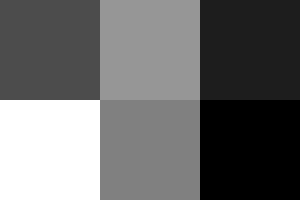

In [139]:
# make gray
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

print(gray)

util.showarray(image=gray, scale_factor=100)

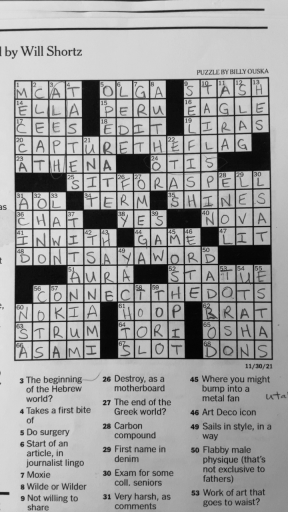

In [140]:
from src.data import image_processor as ip

image = ip.load_image("../data/raw/image_uploads/2021-11-30-2d4a364a-9008-4c2d-8889-e28544fe7315.png")

util.showarray(image=image, scale_factor=.4)

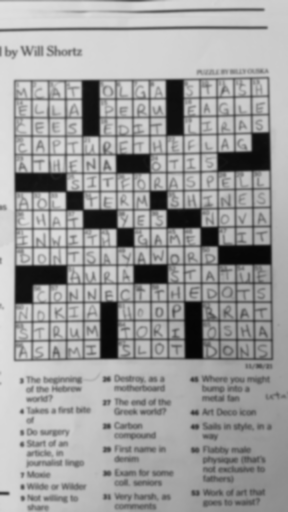

In [141]:
blur = cv2.GaussianBlur(image.copy(), (15,15),0)

util.showarray(blur, scale_factor=.4)

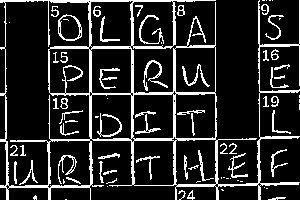

In [143]:
# apply thresholding to make everything black or white.  Adaptive thresholding is used to compensate for different lighting conditions across the image
thresh = cv2.adaptiveThreshold(image.copy(), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 3, 10)
util.showarray(thresh, crop=(200,200,300,200), scale_factor=1)

[[1 1]
 [1 1]]


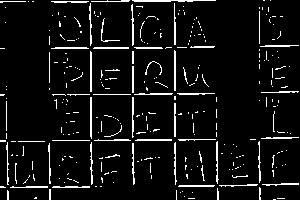

In [146]:
# Erosion: erodes foreground (white) objects. if kernel mask contains a black pixel, make the whole mask black. 
kernel = np.ones((2,2), np.uint8)
print(kernel)
img_erosion = cv2.erode(thresh.copy(), kernel, iterations=1)

util.showarray(img_erosion, crop=(200,200,300,200))

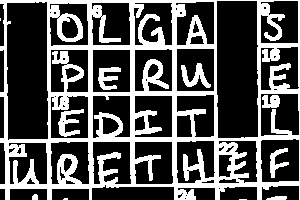

In [180]:
# Dilation: expands foreground (white) objects. if kernel mask contains a white pixel, make the whole mask white. 
kernel = np.ones((3, 3), np.uint8)

img_dilation = cv2.dilate(thresh.copy(), kernel, iterations=1)

util.showarray(img_dilation, crop=(200,200,300,200))


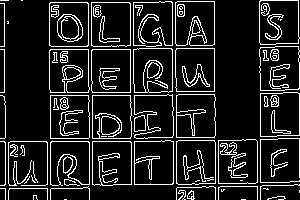

In [220]:
# https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html
canny = cv2.Canny(image.copy(), 100, 200, None, 3)
util.showarray(canny, crop=(200,200,300,200))

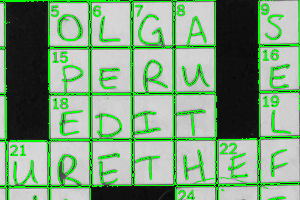

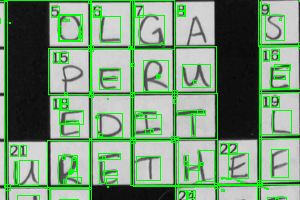

In [222]:
# find countours, the curves that joins all continuous points having the same color or intentsity
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

sorted_ctrs = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

image_contours = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
image_contours_boxes = image_contours.copy()

for i, ctr in enumerate(sorted_ctrs):
    cv2.drawContours(image_contours, sorted_ctrs, i, (0, 255, 0), 1)

    x, y, w, h = cv2.boundingRect(ctr)
    cv2.rectangle(image_contours_boxes, (x, y), (x+w, y+h), color=(0, 255, 0), thickness=1)

util.showarray(image_contours, crop=(200,200,300,200))
util.showarray(image_contours_boxes, crop=(200,200,300,200))

53


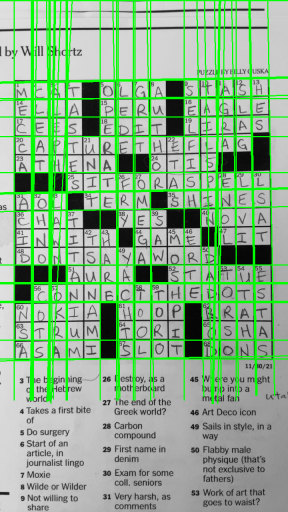

In [263]:
# https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
# https://docs.opencv.org/3.4/d3/de6/tutorial_js_houghlines.html
minLineLength = 100
maxLineGap = 1000
rho = 1
theta = np.pi/180
threshold = 250
image_hough = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)

lines = cv2.HoughLines(canny, 1, np.pi/180, threshold)
for line in lines:
    for rho,theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(image_hough, (x1, y1), (x2, y2), (0, 255, 0), 2)

print(len(lines))
util.showarray(image_hough, scale_factor=.4)